In [1]:
import cv2 as cv
import os
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [2]:
ref_path = os.getcwd() + '/referenceImages'

In [3]:
query_path = os.getcwd() + '/queryImages'

In [4]:
#read image 
def read_image(path):
    # read the image without changing its content
    img = cv.imread(path, cv.IMREAD_UNCHANGED)
    # if there is a mask
    if img.shape[2] == 4:
        # copy the mask
        mask = img[:, :, 3].copy()
        # fill the masked region with white
        img[mask == 0, 0:3] = 255
        return img, mask
    return img, None

In [13]:
#iterate through file names and return descriptors for images using ORB
#https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_orb/py_orb.html
def create_descriptors(images):
    descriptors = []
    path = ''
    detector = cv.ORB.create()
    for image in tqdm(images):
        img, mask = read_image(ref_path+'/'+image)
        gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        kp, des = detector.detectAndCompute(gray, mask)
        descriptors.append([image, des])
    return descriptors
    

In [14]:
#list of file names in reference image folder
ref_images = os.listdir(ref_path)

In [15]:
#creating descriptors for reference images
ref_desc = create_descriptors(ref_images)

100%|██████████| 755/755 [02:17<00:00,  5.47it/s]


In [16]:
#find descriptors for query image
def nearest_neighbor(image, match_num=0):
    FLANN_INDEX_LSH = 0
    index_params= dict(algorithm = FLANN_INDEX_LSH,
                   table_number = 12, 
                   key_size = 20,     
                   multi_probe_level = 2)
    search_params = dict(checks = 100)
    bf = cv.BFMatcher(cv.NORM_HAMMING, crossCheck=True)
    x = []
    #find best matches for each reference image
    for i, desc in enumerate(ref_desc):
        name = desc[0]
        descriptors = desc[1]
        #brute force match
        #https://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_feature2d/py_matcher/py_matcher.html#
        matches = bf.match(descriptors, image)
        #keep top 10 matches
        matches = sorted(matches, key = lambda x: x.distance)[:5]
        x.append([matches, name])
    avg_distances = [(np.mean([y.distance for y in match[0]]), match[1]) for match in x]
    avg_distances = sorted(avg_distances, key=lambda x: x[0])
    #return image with lowest distance matches to query image 
    return avg_distances[match_num][1]

In [36]:
#function to get descriptors for query image and then run nearest neighbors function
def image_retrieval(image_location, match_num=0):
    print('Query Image:')
    img=mpimg.imread(image_location)
    imgplot = plt.imshow(img)
    plt.show()
    #query_image = cv.imread(image_location)
    query_image, mask = read_image(image_location)
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    detector = cv.ORB.create()
    kp, query_image_desc = detector.detectAndCompute(gray, mask)
    #index of closest match
    num = match_num
    x = nearest_neighbor(query_image_desc, match_num=num)
    print('Closest Match:')
    print(x)
    path = os.getcwd() + '/referenceImages/'
    img=mpimg.imread(path+x)
    imgplot = plt.imshow(img)
    plt.show()

In [37]:
query_images = [query_path + '/' + x for x in os.listdir(query_path)][1:]

In [38]:
query_images

['/Users/briansrebrenik/Desktop/cbir/queryImages/10 copy.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/12.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/10.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/0 copy.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/19.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/7.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/54.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/2.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/7 copy.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/1.jpg',
 '/Users/briansrebrenik/Desktop/cbir/queryImages/0.jpg']

In [25]:
!pip install Pillow

     |████████████████████████████████| 3.9MB 2.1MB/s eta 0:00:01     |█▉                              | 215kB 2.1MB/s eta 0:00:02


Query Image:


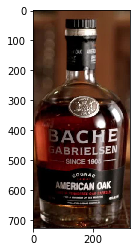

Closest Match:
bache-gabrielsen-american-oak-cognac-[size].png


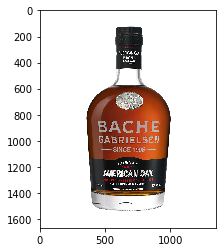

In [41]:
image_retrieval(query_images[8])